# All vs All

In [1]:
import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

import joblib

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from libs.container import Container
from libs.display import d
from libs.nearest import nearest
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

In [2]:
sample = pd.read_pickle("data/o3o4vZ/scaled/s2_5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data_small = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [3]:
sample = pd.read_pickle("data/o3o4vZ/scaled/s5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
data_mid = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [4]:
sample = pd.read_pickle("data/o3o4vZ/scaled/s20k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
data_big = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

## Features

In [5]:
results = {}
cpu = joblib.cpu_count()

In [6]:
cls = {0:0, 1:1}

In [7]:
SIZES = {
    'b220': 211850,
    'b234': 297302,
    'b247': 414497,
    'b248': 426369,
    'b261': 575075,
    'b262': 591770,
    'b263': 585661,
    'b264': 614967,
    'b277': 753146,
    'b278': 781612,
    'b396': 494646}

SP = .1

def get_prec_star(r, tile_name):
    rs = SIZES[tile_name]
    return prec_star(r.y_test, r.probabilities[:,1], r.test_size, rs)

def get_metrics(kf, vss, train_name):
    # kfold correction
    
    pstar = get_prec_star(kf, train_name)
    
    idx = nearest(pstar, SP)
    precs, recs, curve = kf.prec_rec_curve
    kfold_prec = precs[idx]
    kfold_recall = recs[idx]
    
    m = Container(
        kfold=(kfold_prec, kfold_recall, pstar, precs, recs), vss=Container())
    
    for vs in vss:
        pstar = get_prec_star(vs, vs.test_name)
        idx = nearest(pstar, SP)
        
        precs, recs, curve = vs.prec_rec_curve
        prec = precs[idx]
        recall = recs[idx]
        m.vss[vs.test_name] = (prec, recall, pstar, precs, recs)
    
    return m


def run(train, data):
    print ">>>> Kfolding {} <<<<".format(train)
    kf = KFoldExperiment(
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu), clsnum=cls, 
        data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls", verbose=False)
    kf = kf(train, nfolds=10)
    
    print ">>>> Vs {}<<<<".format(train)
    vs = WithAnotherExperiment(
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu), verbose=False, 
        clsnum=cls, data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls")
    vs = vs(train)
    
    return train, get_metrics(kf=kf, vss=vs, train_name=train)

In [8]:
cpu = joblib.cpu_count()
print cpu

48


In [9]:
with joblib.Parallel(n_jobs=cpu) as jobs:
    result = jobs(
        joblib.delayed(run)(k, data_small)
        for k in sorted(data_small.keys()))
results["small"] = dict(result)

>>>> Kfolding b220 <<<<
>>>> Kfolding b234 <<<<
>>>> Kfolding b247 <<<<
>>>> Kfolding b248 <<<<
>>>> Kfolding b261 <<<<
>>>> Kfolding b262 <<<<
>>>> Kfolding b263 <<<<
>>>> Kfolding b264 <<<<
>>>> Kfolding b277 <<<<
>>>> Kfolding b278 <<<<
>>>> Kfolding b396 <<<<
>>>> Vs b220<<<<
>>>> Vs b234<<<<
>>>> Vs b248<<<<
>>>> Vs b247<<<<
>>>> Vs b263<<<<
>>>> Vs b396<<<<
>>>> Vs b262<<<<
>>>> Vs b261<<<<
>>>> Vs b264<<<<
>>>> Vs b277<<<<
>>>> Vs b278<<<<


In [10]:
with joblib.Parallel(n_jobs=cpu) as jobs:
    result = jobs(
        joblib.delayed(run)(k, data_mid)
        for k in sorted(data_mid.keys()))
results["mid"] = dict(result)

>>>> Kfolding b220 <<<<
>>>> Kfolding b234 <<<<
>>>> Kfolding b247 <<<<
>>>> Kfolding b248 <<<<
>>>> Kfolding b261 <<<<
>>>> Kfolding b262 <<<<
>>>> Kfolding b263 <<<<
>>>> Kfolding b264 <<<<
>>>> Kfolding b277 <<<<
>>>> Kfolding b278 <<<<
>>>> Kfolding b396 <<<<
>>>> Vs b220<<<<
>>>> Vs b234<<<<
>>>> Vs b247<<<<
>>>> Vs b248<<<<
>>>> Vs b396<<<<
>>>> Vs b261<<<<
>>>> Vs b263<<<<
>>>> Vs b264<<<<
>>>> Vs b278<<<<
>>>> Vs b262<<<<
>>>> Vs b277<<<<


In [11]:
with joblib.Parallel(n_jobs=cpu) as jobs:
    result = jobs(
        joblib.delayed(run)(k, data_big)
        for k in sorted(data_big.keys()))
results["big"] = dict(result)

>>>> Kfolding b220 <<<<
>>>> Kfolding b234 <<<<
>>>> Kfolding b247 <<<<
>>>> Kfolding b248 <<<<
>>>> Kfolding b261 <<<<
>>>> Kfolding b262 <<<<
>>>> Kfolding b263 <<<<
>>>> Kfolding b264 <<<<
>>>> Kfolding b277 <<<<
>>>> Kfolding b278 <<<<
>>>> Kfolding b396 <<<<
>>>> Vs b220<<<<
>>>> Vs b234<<<<
>>>> Vs b247<<<<
>>>> Vs b396<<<<
>>>> Vs b248<<<<
>>>> Vs b261<<<<
>>>> Vs b264<<<<
>>>> Vs b262<<<<
>>>> Vs b263<<<<
>>>> Vs b277<<<<
>>>> Vs b278<<<<


In [12]:
np.save("data/o3o4vZ/all_vs_all_vs/results.npy", [results])

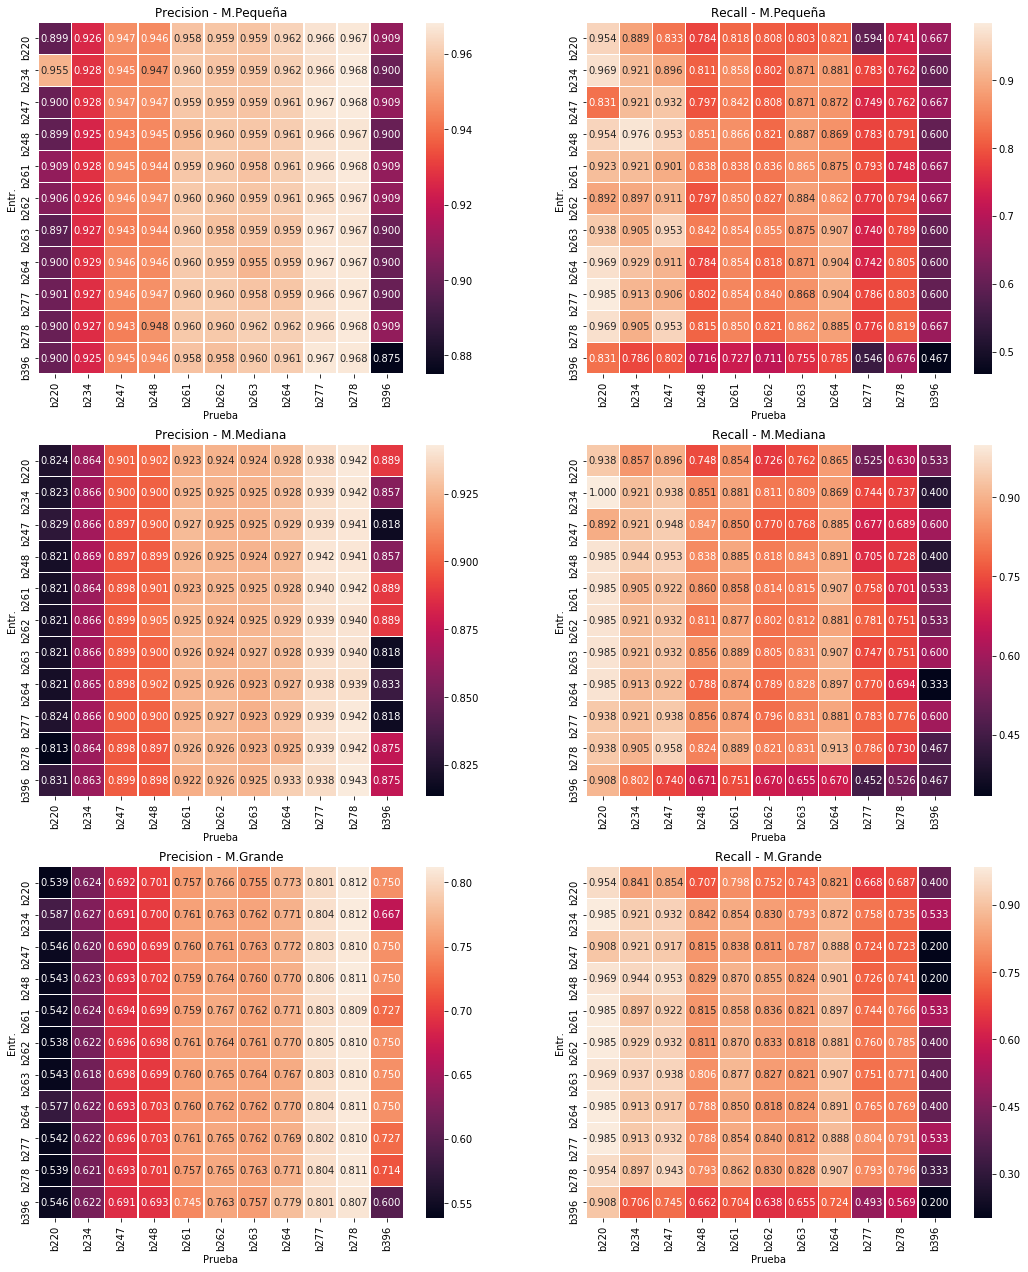

In [13]:
SIZES = {
    "big": "Grd",
    "small": u"Peq",
    "mid": "Med"
}

rows = []
for size in ["small", "mid", "big"]:
    sdata = results[size]
    for train, tdata in sorted(sdata.items()):
        row = {
            "Muestra": SIZES[size],
            "Entr.": train, 
            (train, "prec"): tdata.kfold[0], 
            (train, "rec"): tdata.kfold[1]}
        for k, v in sorted(tdata.vss.items()):
            row.update({(k, "prec"): v[0], (k, "rec"): v[1]})
        rows.append(row)
        

raw = pd.DataFrame(rows).set_index(["Muestra", "Entr."])
raw.columns = pd.MultiIndex.from_tuples(raw.columns.values)

fig, aax = plt.subplots(3, 2, figsize=(18, 22))

def draw(ax, df, suffix):
    sns.heatmap(df.swaplevel(0, 1, axis=1)[["prec"]], annot=True, fmt='.3f',  linewidths=.5, ax=ax[0]);

    sns.heatmap(df.swaplevel(0, 1, axis=1)[["rec"]], annot=True, fmt='.3f', linewidths=.5, ax=ax[1]);

    labels = [l.get_text().split("-", 1)[-1] for l in ax[0].get_xticklabels()]
    ax[0].set_xticklabels(labels)
    ax[1].set_xticklabels(labels)

    ax[0].set_title(u"Precision - M.{}".format(suffix))
    ax[1].set_title(u"Recall - M.{}".format(suffix))

    ax[0].set_xlabel("Prueba")
    ax[1].set_xlabel("Prueba")

draw(ax=aax[0], df=raw.loc["Peq"], suffix=u"Pequeña")
draw(ax=aax[1], df=raw.loc["Med"], suffix=u"Mediana")
draw(ax=aax[2], df=raw.loc["Grd"], suffix=u"Grande")

import datetime
# fname = "workpoint_{}.pdf".format(datetime.datetime.now().isoformat())
# print fname
# plt.savefig(fname)
plt.show()

In [14]:
precs, pstars = {}, {}
for size, sdata in results.items():
    psize = []
    prec = []
    for train, tdata in sdata.items():
        psize.extend(tdata.kfold[2])
        prec.extend(tdata.kfold[3])
        for k, v in sorted(tdata.vss.items()):
            psize.extend(v[2])
            prec.extend(v[3])
    
    psize = np.array(psize)
    flt = (psize < 1)
    
    precs[size] = np.array(prec)[flt]
    pstars[size] = psize[flt]

In [15]:
sample_size = min(map(len, pstars.values()))
sampled = {}
for size, ps in pstars.items():
    if len(ps) != sample_size:
        np.random.shuffle(ps)
        ps = ps[:sample_size]
    sampled[size] = ps

df = pd.DataFrame(sampled)

In [16]:
df.describe()

,big,mid,small
count,21139.000000,21139.000000,21139.000000
mean,0.241896,0.117786,0.091543
std,0.254474,0.166345,0.133064
min,0.000000,0.000000,0.000000
25%,0.037272,0.011571,0.007647
50%,0.127392,0.037197,0.025359
75%,0.413138,0.149899,0.116552
max,0.871251,0.676484,0.545150


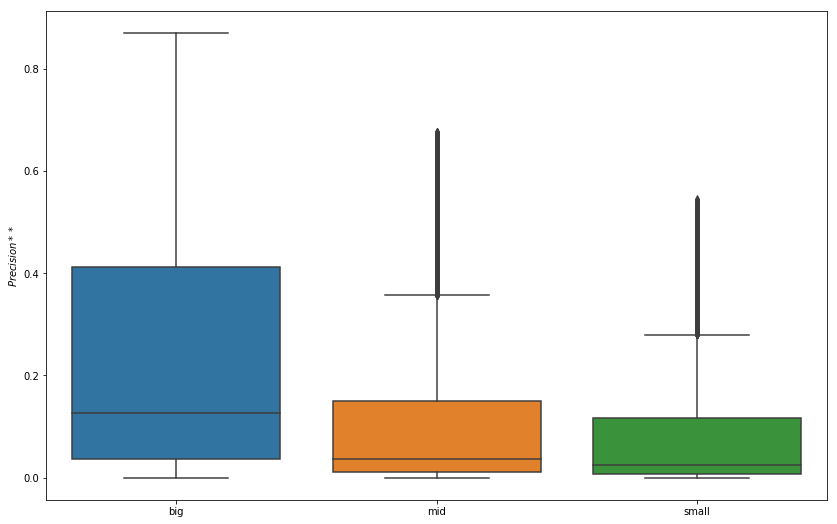

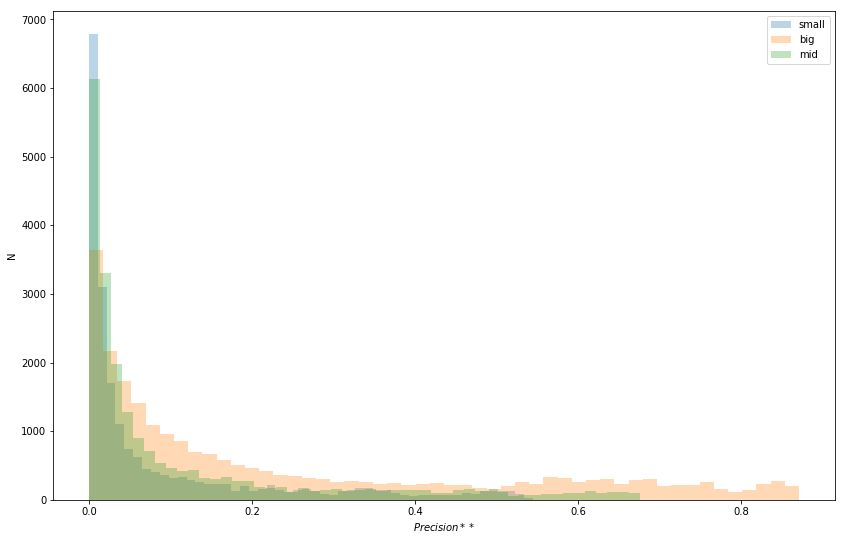

In [17]:
fig, axis = plt.subplots()
fig.set_size_inches(14, 9)

sns.boxplot(data=df);
plt.ylabel("$Precision**$");
plt.show();

fig, axis = plt.subplots()
fig.set_size_inches(14, 9)
for size, ps in pstars.items():
    axis.hist(ps, label=size, alpha=.3, bins=50)
    
    
plt.xlabel("$Precision**$")
plt.ylabel("N")
plt.legend();

In [18]:
size

'mid'

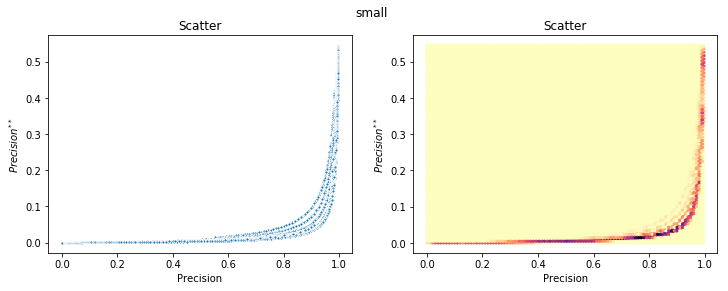

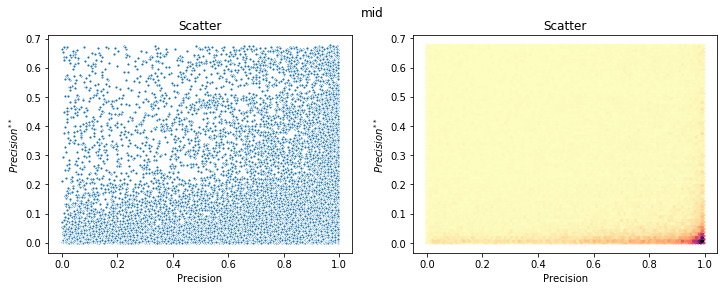

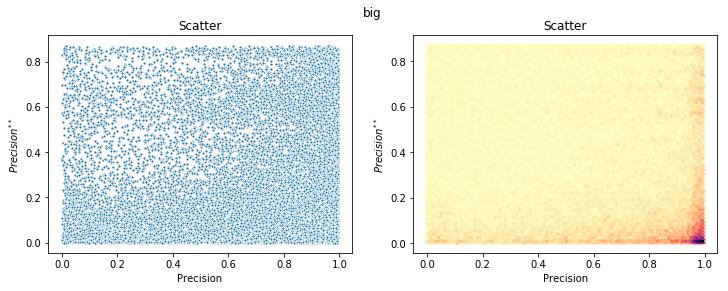

In [33]:
for size in ["small", "mid", "big"]:
    x, y = precs[size], pstars[size]
    
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(12, 4)
    fig.suptitle(size)
    
    ax[0].set_title("Scatter")
    ax[0].set_xlabel("Precision")
    ax[0].set_ylabel("$Precision^{**}$")
    sns.scatterplot(x, y, ax=ax[0], marker=".")
    
    ax[1].set_title("Scatter")
    ax[1].set_xlabel("Precision")
    ax[1].set_ylabel("$Precision^{**}$")
    ax[1].hexbin(x, y, cmap="magma_r")
    
    plt.show()
    